# Convolutional Neural Network

## Packages

In [43]:
# ----- Tensorflow -----
import tensorflow as tf
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras import optimizers as opt

# ----- Transfer learning -----
from keras.applications import NASNetLarge
from keras.applications import EfficientNetB0
from keras.applications import MobileNetV2

# ----- plot -----
import matplotlib.pyplot as plt

# ----- Utility functions -----
from utils import load_data, plot_hist, plot_hist_sideways, _convert_sample

# ------ Data ------
import numpy as np


## Load Data

In [44]:
data_dir = "D:/OneDrive - Syddansk Universitet/kandidat/3_semester/Maskinlæring/ds807_anvendt_maskinlæring/eksamen/exam/patch_camelyon"
BATCH_SIZE = 32
train, test, val = load_data(data_dir, perc=1, batch_size=BATCH_SIZE)

## Transfer Learning
- Discuss and apply transfer learning. Motivate what type of transfer learning you use and how you apply it, including considerations for how to prepare the data for this. Here, be sure to visualize plots of train and validation losses and accuracies.



## Feature Extraction Approach
For the feature extraction approach, we will utilize a large network, since we do not have to train it, we can utilize its size and save computational ressources. In this case we are using NasNetLarge, since it is one of the best performing models in terms of accuracy for image classification. However, it is a HUGE model, and will take time to even load.
However, we will also try with mobilenet v2 since it has been trained on 96 x 96 pixel images

### Helper Functions

In [52]:
def get_x(dataset):
    """
    Returns all y from tensorflow data set
    """
    return tf.convert_to_tensor([x for _, x in dataset.unbatch()])

def get_y(dataset):
    """
    Returns all x from a tensorflow data set
    """
    return tf.convert_to_tensor([y for _, y in dataset.unbatch()])

def get_x_y(dataset):
    """
    Returns all x and y from a tensorflow data set
    """
    return get_x(dataset), get_y(dataset) 


### Build Feature Extractor with NasNet Large

#### Feature Extractor

In [46]:
# Initilize NasNetLarge Feature Extractor
NasNet_ft_extractor = NASNetLarge(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
NasNet_ft_extractor.trainable = False

#### Classifier

In [47]:
# Build classifer
x = NasNet_ft_extractor.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_nasnet = Model(inputs = NasNet_ft_extractor.output, outputs = output)

# Compile model
m_nasnet.compile(
    optimizer = opt.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [55]:
# X features
nasnet_fts_train = NasNet_ft_extractor.predict(train)
nasnet_fts_val = NasNet_ft_extractor.predict(val)

11/11 [==============================] - 13s 1s/step


In [56]:
# Y labels 
y_train = get_y(train)
y_val = get_y(val)

#### Train model with Nasnet Extractor

In [57]:
history_nasnet = m_nasnet.fit(x = nasnet_fts_train, y = y_train, validation_data = (nasnet_fts_val, y_val), epochs = 5, batch_size = 32)


Epoch 1/5
82/82 [==============================] - 36s 440ms/step - loss: 0.3407 - accuracy: 0.8882 - val_loss: 0.6276 - val_accuracy: 0.7317
Epoch 2/5
82/82 [==============================] - 36s 440ms/step - loss: 0.2323 - accuracy: 0.9523 - val_loss: 0.8303 - val_accuracy: 0.7439
Epoch 3/5
82/82 [==============================] - 35s 432ms/step - loss: 0.1248 - accuracy: 0.9832 - val_loss: 1.0110 - val_accuracy: 0.7195
Epoch 4/5
82/82 [==============================] - 36s 438ms/step - loss: 0.0118 - accuracy: 0.9985 - val_loss: 1.1873 - val_accuracy: 0.7622
Epoch 5/5
82/82 [==============================] - 36s 440ms/step - loss: 0.0912 - accuracy: 0.9748 - val_loss: 1.0041 - val_accuracy: 0.7409


### Feature extractor with MobileNetV2

#### Feature Extractor

In [59]:
# Layers for feature extraction
mobilev2_ft_extractor = MobileNetV2(
    input_shape=(96, 96, 3),
    include_top= False,
    weights='imagenet'
)
mobilev2_ft_extractor.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


#### Classifier

In [66]:
# Full model
x = mobilev2_ft_extractor.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output = Dense(2, activation='softmax')(x)
m_mobilev2 = Model(inputs = mobilev2_ft_extractor.output, outputs = output)

# Compile model
# Compile model
m_mobilev2.compile(
    optimizer = opt.Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

#### Extract Features

In [67]:
# Extract Features
mobilev2_fts_train = mobilev2_ft_extractor.predict(train)
mobilev2_fts_val = mobilev2_ft_extractor.predict(val)

11/11 [==============================] - 1s 111ms/step


#### Train model with mobilev2 ft extractor

In [68]:
history_mobile_v2 = m_mobilev2.fit(x = mobilev2_fts_train, y = y_train, validation_data = val, epochs = 5)

Epoch 1/5
82/82 [==============================] - ETA: 0s - loss: 0.9070 - accuracy: 0.7215

ValueError: in user code:

    File "c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\keras\engine\training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\keras\engine\training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\keras\engine\training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\keras\engine\training.py", line 1756, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\chris\Desktop\applied_ML_faelles\.venv\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 3, 3, 1280), found shape=(None, 96, 96, 3)


### Plot Results

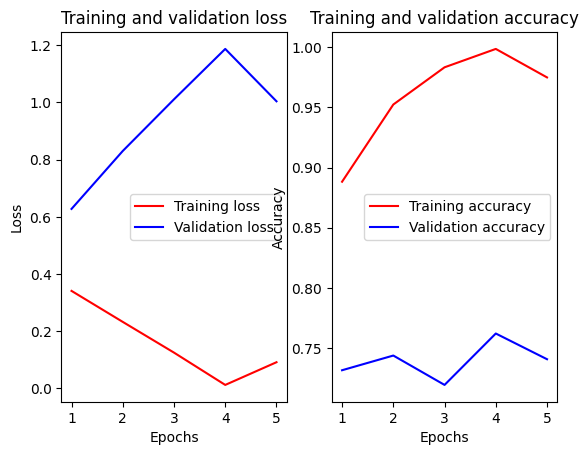

In [58]:
plot_hist_sideways(history_nasnet)

In [ ]:
plot_hist_sideways(history_mobile_v2)

## Fine Tuning Approach
- For our fine tuning approach we will use a smaller and more efficient model, since we will be retraining it. We are therefore, using EfficientNet B0